In [327]:
# The codes for the backtest system contains a large proportion
# transformed from the matlab codes in the homework. 
# Most original comments are remained for the Markowitz part.
# In the Black Litterman part, to avoid redundancy, only the things
# different from Markowitz have comments. 
# Comments following "#//" are codes used to debug only. They can be 
# totally ignored.

##########################################
#### * #######  PREPARAION  ####### * ####
##########################################

import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

In [328]:
# Import data and store them in matrices
risk_free_rate = pd.read_csv(r'D:\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'D:\new_price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
nc = Price.shape[1] # number of columns

In [329]:
Super = pd.read_csv(r'D:\new_super_big_data.csv', index_col=0, header=0)
Returns = np.mat(Super.iloc[:,range(120,120+30,1)])
Variance = np.mat(Super.iloc[:,range(0,0+nc*3,3)])
Skewness = np.mat(Super.iloc[:,range(1,1+nc*3,3)])
Kurtosis = np.mat(Super.iloc[:,range(2,2+nc*3,3)])

In [330]:
import pickle
with open('./weekly_panel_matrices', 'rb') as f:
    pm = pickle.load(f)

In [331]:
with open('./inverted_index', 'rb') as f:
    id = pickle.load(f)

In [332]:
id[5]

Timestamp('2013-03-12 00:00:00')

In [375]:
np.mat(pm[0][id[0]].as_matrix())

KeyError: Timestamp('2013-03-05 00:00:00')

In [334]:
# # The random signal here is only used to test whether the system works, it can be replaced by any signal.
# random_signal = np.random.uniform(20,100,1255*30)
# random_signal = random_signal.reshape([1255,30])
# random_signal = pd.DataFrame(random_signal,columns=range(1,31,1),index=range(1,1256,1))
# random_signal = np.mat(random_signal)

In [335]:
##########################################
#### * ########  FUNCTION  ######## * ####
##########################################

# Turn the signal matrix into a ranking matrix where the value for each entry 
# refers to the ranking of of the asset's signal among all assets' signals in
# the specific period.
# In the output matrix, each row will look like 3,24,1,535,12,18... the 3 here
# means the first asset has the third smallest signal in that period.
def ranking(signal_matrix):
    rank_matrix = np.zeros(signal_matrix.shape)
    rank_matrix = np.mat(rank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    del element_list[0]
                    r=r+1
                    break
                    
    return rank_matrix         

In [336]:
# Very similar to the ranking function above. The only difference is that here signal 
# values are sorted and divided into groups, where assets in each group has the same 
# groupranking.
# In the output matrix, a row may look like 1,1,5,2,2,4,3,3..., which means the first 
# and second assets are in the group with smallest signal values.
# PRECONDITION: number_of_colmns%number_of_groups==0 
def ngroupranking(signal_matrix,number_of_groups):
    rank_matrix = np.zeros(signal_matrix.shape)
    grouprank_matrix = np.zeros(signal_matrix.shape)
    #print rank_matrix.dtype
    rank_matrix = np.mat(rank_matrix)
    grouprank_matrix = np.mat(grouprank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    distance = nc/number_of_groups
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort() 
        rank_index=range(30)
        r=1
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    grouprank_matrix[i,j] = float(int(r-1)/int(distance)+1)
                    del element_list[0]
                    r=r+1
                    break
                    
    return rank_matrix,grouprank_matrix  

#// test = ngroupranking(Skewness,3)[1]
#// for i in range(1000):
    #// for j in range(20):
        #// if (test[i,j]!=1.0 and test[i,j]!=2.0 and test[i,j]!=3.0):
            #// print i,j,test[i,j]

In [337]:
test = ngroupranking(Skewness,2)[1]

In [338]:
test[0]

matrix([[ 2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
          1.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
          1.,  1.,  1.,  1.]])

In [339]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency 
    n_s = number_of_samples
    r_d = rate_of_decay

    s_d = t_d-1-np.arange(n_s+1)*s_f # reverse chronological   
    s_d = s_d[::-1] # chronological    
        # sample dates, a row vector

    S_P = P[s_d,:] # Sample Prices, a matrix
    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    
    # Now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    # covariance matrix of compound returns

    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    # adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    # adapting covariance matrix to length of holding period

    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    mu = muu - 1 # resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    # resulting covariance matrix of ARITHMETIC returns   
    
    return mu,V

In [340]:
# This function takes in a groupranking signal matrix and remains only 
# the group investor believe will outperform the market, with a coefficient
# 1 for each the assets in that group and 0 for others.
# Each row looks like 0,0,0,1,1,0,1,...
# PRECONDITION: outperforming_ranking is an integer existing in the GroupSignal
def view_ranking_signal(GroupSignal,outperforming_ranking):
    view_rank = GroupSignal
    for i in range(view_rank.shape[0]):
        for j in range(view_rank.shape[1]):
            if (view_rank[i,j]!=outperforming_ranking):
                view_rank[i,j] = 0
    view_rank = view_rank/outperforming_ranking
    
    return view_rank

In [341]:
## test, view_ranking_signal(GroupSignal,outperforming_ranking)
# // testx = [[1,3,2,4,5],[2,3,4,1,5],[2,4,5,1,3]]
# // testx = np.mat(testx)
# // testx
# // view_ranking_signal(testx,3)

In [342]:
# This function can be regarded as an additional stats function for the Black Litterman model,
# which shows the investor views through three outputs: A, Omega(which is U in lecture notes, 
# but we have used "U" for cholesky factorization, so we use another name here), and b.
# At1,At2,At3 are integers among 1,2,3, which refers to the outperforming_ranking in the 
# above view_ranking_signal function.
# PRECONDITION: Signal1, Signal2, Signal3 are of the same size.
def hybrid_investor_view(Signal1,Signal2,Signal3,At1,At2,At3,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S1 = Signal1 # the Signal matrix, each row refer to a date and each column refers to an asset
    S2 = Signal2
    S3 = Signal3
    
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S1 = S1[s_d,:] #Sample Signals, a matrix
    S_S2 = S2[s_d,:]
    S_S3 = S3[s_d,:]

    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r1 = S_S1.T*wt
    mean_c_r2 = S_S2.T*wt
    mean_c_r3 = S_S3.T*wt
    #// print mean_c_r.T
    GroupSignal1 = ngroupranking(mean_c_r1.T,3)[1].T
    GroupSignal2 = ngroupranking(mean_c_r2.T,3)[1].T
    GroupSignal3 = ngroupranking(mean_c_r3.T,3)[1].T
    view_rank1 = view_ranking_signal(GroupSignal1,At1)
    view_rank2 = view_ranking_signal(GroupSignal2,At2)
    view_rank3 = view_ranking_signal(GroupSignal3,At3)
    #// print ngroupranking(mean_c_r.T,3)[1].dtype
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    var_signal1 = np.var(S_S1) # the variance of all signal values in the samples 
    var_signal2 = np.var(S_S2)
    var_signal3 = np.var(S_S3) 
    A1 = view_rank1.T
    A2 = view_rank2.T
    A3 = view_rank3.T
    A = np.mat([np.ndarray.tolist(A1[0])[0],np.ndarray.tolist(A2[0])[0],np.ndarray.tolist(A3[0])[0]])
    Omega = np.mat(np.diag([var_signal1,var_signal2,var_signal3]))    
    b1 = np.sum(S_R*A1.T)
    b2 = np.sum(S_R*A2.T)
    b3 = np.sum(S_R*A3.T)    
    b = np.mat([b1,b2,b3]).T
    
    return A,Omega,b
#// atest = investor_view(Skewness,Returns,120,1,5,0)[0]

In [343]:
# This function can be regarded as an additional stats function for the Black Litterman model,
# which shows the investor views through three outputs: A, Omega(which is U in lecture notes, 
# but we have used "U" for cholesky factorization, so we use another name here), and b.
# At1,At2 are integers among 1,2, which refers to the outperforming_ranking in the 
# above view_ranking_signal function.
# PRECONDITION: Signal1, Signal2  are of the same size.

def double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S1 = Signal1 # the Signal matrix, each row refer to a date and each column refers to an asset
    S2 = Signal2
    
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S1 = S1[s_d,:] #Sample Signals, a matrix
    S_S2 = S2[s_d,:]

    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r1 = S_S1.T*wt
    mean_c_r2 = S_S2.T*wt
    
    
    #print mean_c_r1.T
    
    GroupSignal1 = ngroupranking(mean_c_r1.T,3)[1].T
    GroupSignal2 = ngroupranking(mean_c_r2.T,3)[1].T
    view_rank1 = view_ranking_signal(GroupSignal1,At1)
    view_rank2 = view_ranking_signal(GroupSignal2,At2)
    
    #print GroupSignal1
    #print view_rank1
    #print ngroupranking(mean_c_r1.T,3)[1]
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    var_signal1 = np.var(S_S1) # the variance of all signal values in the samples 
    var_signal2 = np.var(S_S2)
    
    A1 = view_rank1.T
    A2 = view_rank2.T
    
    #print A1
    
    A = np.mat([np.ndarray.tolist(A1[0])[0],np.ndarray.tolist(A2[0])[0]])
    Omega = np.mat(np.diag([var_signal1,var_signal2]))    
    b1 = np.sum(S_R*A1.T)
    b2 = np.sum(S_R*A2.T)   
    b = np.mat([b1,b2]).T
    
    return A,Omega,b

In [344]:
# This function can be regarded as an additional stats function for the Black Litterman model,
# which shows the investor views through three outputs: A, Omega(which is U in lecture notes, 
# but we have used "U" for cholesky factorization, so we use another name here), and b.
# At1,At2 are integers among 1,2, which refers to the outperforming_ranking in the 
# above view_ranking_signal function.
# PRECONDITION: Signal1, Signal2  are of the same size.

def single_investor_view(Signal1,At1,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S1 = Signal1 # the Signal matrix, each row refer to a date and each column refers to an asset
    
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S1 = S1[s_d,:] #Sample Signals, a matrix

    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r1 = S_S1.T*wt
    
    
    #print mean_c_r1.T
    
    GroupSignal1 = ngroupranking(mean_c_r1.T,3)[1].T
    view_rank1 = view_ranking_signal(GroupSignal1,At1)
    
    #print GroupSignal1
    #print view_rank1
    #print ngroupranking(mean_c_r1.T,3)[1]
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    var_signal1 = np.var(S_S1) # the variance of all signal values in the samples 
    
    A1 = view_rank1.T
    
    #print A1
    
    A = np.mat(A1)
    Omega = np.mat(np.diag([var_signal1]))    
    b1 = np.sum(S_R*A1.T)
    b = np.mat([b1]).T
    
    return A,Omega,b

In [345]:
#atest = double_investor_view(Skewness,Returns,120,1,5,0)[0]
#atest=double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)

In [346]:
#atest

In [347]:
# A simple version of the above function where only one signal is considered.
# When introducing the Signal matrix, the assumption is: Smaller skewness, better asset.
def investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S = Signal # the Signal matrix, each row refer to a date and each column refers to an asset
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S = S[s_d,:] #Sample Signals, a matrix
    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r = S_S.T*wt
    #// print mean_c_r.T
    view_rank = ngroupranking(mean_c_r.T,3)[1].T
    #// print ngroupranking(mean_c_r.T,3)[1].dtype
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    view_rank = view_rank%3
    view_rank = view_rank%2
    ###########    View on the skewness    ########
    skewness_small = view_rank.T
    var_skewness = np.var(S_S)# the var of 
    A = skewness_small
    Omega = np.mat(var_skewness)
    b_skewness = np.sum(S_R*A.T)
    b = np.mat(b_skewness)
    
    return A,Omega,b

#// atest = investor_view(Skewness,Returns,120,1,5,0)[0]

In [348]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under markowitz model
def markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu0*x0+mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.05 # a little change 
                   # Alternative constraints in homework, which are not used here:
                   # 0.05<=x,
                   # x<=0.2,
                   # x[1]+x[4]<=x[5]+x[6]+x[8],
                   # sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    #// print "status:", prob.status
    #// print "optimal value", prob.value
    #// print "optimal var", x.value, y.value
    
    return x0.value,x.value

In [349]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under markowitz model
def markowitz_risky(mu,V,sigma,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   sum_entries(x)==1,
                   x==xx+y,
                   #trans_cost*sum_entries(abs(y))==total_trans_cost,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()
    return x.value

In [350]:
def Rmax(R):
    n = len(R)
    x = Variable(n)
    objective = Maximize(R.T*x)
    constraints = [sum_entries(x)==1,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    return result

In [351]:
def Vmin(V):
    n = len(V)
    U = np.linalg.cholesky(V) 
    x = Variable(n)
    
    objective = Minimize(norm(U*x))
    constraints = [sum_entries(x)==1,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    return result

In [352]:
'''
#REFERENCE: https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html
#Rhttps://stackoverflow.com/questions/18767657/how-do-i-use-a-minimization-function-in-scipy-with-constraints
import scipy
from scipy.optimize import minimize
def Scurrent(x,S):
    x2 = np.multiply(np.mat(x),np.mat(x))
    Xm = x2.T*np.mat(x)
    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))
    s = np.mat(S.diagonal())
    #s3 = np.multiply(np.multiply(s,s),s)

    left = float(x3*s.T)
    right = np.sum(np.multiply(Xm,S))
    res = -5*left+6*right
    return res

def Smax(S,xx):
    def Smaxob(x):
        Max = -Scurrent(x,S)
        return Max
    def con(x):
        return np.sum(x)-1
    n = len(S)
    bnds = tuple((0,1) for x in xx)
    cons = {'type':'eq','fun':con}
    result = minimize(Smaxob, xx, bounds=bnds, constraints=cons).fun
    return -result
'''

"\n#REFERENCE: https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html\n#Rhttps://stackoverflow.com/questions/18767657/how-do-i-use-a-minimization-function-in-scipy-with-constraints\nimport scipy\nfrom scipy.optimize import minimize\ndef Scurrent(x,S):\n    x2 = np.multiply(np.mat(x),np.mat(x))\n    Xm = x2.T*np.mat(x)\n    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))\n    s = np.mat(S.diagonal())\n    #s3 = np.multiply(np.multiply(s,s),s)\n\n    left = float(x3*s.T)\n    right = np.sum(np.multiply(Xm,S))\n    res = -5*left+6*right\n    return res\n\ndef Smax(S,xx):\n    def Smaxob(x):\n        Max = -Scurrent(x,S)\n        return Max\n    def con(x):\n        return np.sum(x)-1\n    n = len(S)\n    bnds = tuple((0,1) for x in xx)\n    cons = {'type':'eq','fun':con}\n    result = minimize(Smaxob, xx, bounds=bnds, constraints=cons).fun\n    return -result\n"

In [353]:
#REFERENCE: https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html
#Rhttps://stackoverflow.com/questions/18767657/how-do-i-use-a-minimization-function-in-scipy-with-constraints
import scipy
from scipy.optimize import minimize
def Scurrent(x,S):
    x2 = np.multiply(np.mat(x),np.mat(x))
    Xm1 = x2.T*np.mat(x)
    Xm2 = np.mat(x).T*x2
    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))
    s = np.mat(S.diagonal())
    #s3 = np.multiply(np.multiply(s,s),s)

    left = float(x3*s.T)
    mid1 = np.sum(np.multiply(Xm1,S))
    mid2 = np.sum(np.multiply(Xm2,S.T))
    res = -5*left+3*mid1+3*mid2
    return res



In [354]:
def Kcurrent(x,K1,K2):
    x2 = np.multiply(np.mat(x),np.mat(x))
    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))
    x4 = np.multiply(np.mat(x2),np.mat(x2))    
    Xm1 = x3.T*np.mat(x)
    Xm2 = np.mat(x).T*x3    
    Xr = x2.T*x2

    k = np.mat(K1.diagonal())
    #k4 = np.multiply(np.multiply(np.multiply(k,k),k),k)

    left = float(x4*k.T)
    mid1 = np.sum(np.multiply(Xm1,K1))
    mid2 = np.sum(np.multiply(Xm2,K1.T))
    right = np.sum(np.multiply(Xr,K2))
    res = -13*left+4*mid1+4*mid2+6*right
    return res



In [355]:
def PGP(R,V,S,K1,K2,xx,trans_cost):
    lambda1 = 2.
    lambda2 = 2.
    lambda3 = 2.
    lambda4 = 2.
    xx = xx
    n = len(V)
    #print xx
    def Smax(S,xx):
        def Smaxob(x):
            Max = -Scurrent(x,S)
            return Max
        def con(x):
            return np.sum(x)-1
        n = len(S)
        bnds = tuple((0,1) for i in range(n))
        cons = {'type':'eq','fun':con}
        result = minimize(Smaxob, xx, bounds=bnds, constraints=cons).fun
        return -result
    #print xx
    #print Smax(S,xx)
    Sm = Smax(S,xx)
    def Kmin(K1,K2,xx):
        def Kminob(x):
            Min = Kcurrent(x,K1,K2)
            return Min

        def con(x):
            return np.sum(x)-1
        n = len(K1)
        bnds = tuple((0,1) for i in range(n))
        cons = {'type':'eq','fun':con}
        result = minimize(Kminob, xx, bounds=bnds, constraints=cons).fun
        return result
    #print xx
    #print Kmin(K1,K2,xx)
    Km = Kmin(K1,K2,xx)
    def PGPob(x):
        Rstar = Rmax(R)
        Vstar = Vmin(V)
        Sstar = Sm
        Kstar = Km  

        Rcurrent = float(np.dot(x,R))
        Vcurrent = float(np.dot(np.dot(np.mat(x),V),np.mat(x).T))

        d1 = Rstar-Rcurrent
        d2 = Vcurrent-Vstar
        d3 = Sstar-Scurrent(x,S)
        d4 = Kcurrent(x,K1,K2)-Kstar

        Min = (((d1/Rstar))**lambda1
               +((d2/Vstar))**lambda2
               +((d3/Sstar))**lambda3
               +((d4/Kstar))**lambda4)
        return Min

    def con(x):
        return np.sum(x)+np.sum(np.abs(x-xx))*trans_cost-1.
    
    bnds = tuple((0,1) for i in range(n))
    cons = {'type':'eq','fun':con}
    result = minimize(PGPob, xx, bounds=bnds, constraints=cons)
    return result.x

In [356]:
n=30
xx = np.ones(n)*1./float(n)
R = np.ones(n)*1./float(n)
V = np.mat(pm[0][id[5]].as_matrix())[:n,:n]
S = np.mat(pm[1][id[5]].as_matrix())[:n,:n]
K1 = np.mat(pm[2][id[5]].as_matrix())[:n,:n]
K2 = np.mat(pm[3][id[5]].as_matrix())[:n,:n]
trans_cost = 0.0005
PGP(R,V,S,K1,K2,xx,trans_cost)

array([ 0.03782792,  0.04593376,  0.0220695 ,  0.0367557 ,  0.03628556,
        0.0369775 ,  0.03554905,  0.02848176,  0.031417  ,  0.02327549,
        0.0472298 ,  0.02534483,  0.04648523,  0.03961092,  0.02020669,
        0.03730431,  0.02869784,  0.02646349,  0.02691592,  0.04467847,
        0.02912119,  0.03628812,  0.02094352,  0.03399021,  0.031482  ,
        0.02947405,  0.02872268,  0.02850826,  0.0276148 ,  0.05623989])

In [357]:
xx

array([ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333])

In [358]:
print V[3,5]
print V[5,3]
print S[3,5]
print S[5,3]
print K1[3,5]
print K1[5,3]
print K2[3,5]
print K2[5,3]

9.05200641453e-07
9.05200641453e-07
0.0723465927623
0.312646430504
1.60620265646
1.60620265646
0.56240120275
0.306841468869


In [359]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under black litterman model
# Compared with the markowitz function, the input contains three additional
# parameters: A, Omega(which is U in lecture notes), and b
def blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b,tau=1):
    n = len(mu)
    #// print b
    #// print "Omega.shape:",Omega.shape
    #// print "Omegainv",np.linalg.inv(Omega)
    #// print "V.shape:",V.shape
    #// print "Vinv",np.linalg.inv(V)
    #// print Omega.dtype
    #// print V.dtype
    #// print A.dtype
    #// print (A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V)).shape
    V=tau*V
    middle = np.mat(A.T*Omega.I*A+V.I) # A intermediate variable, for computation only
    #// print middle.dtype
    #// middle.dtype = 'float32'
    #// print middle.shape
    #// print np.linalg.det(middle)
    #// print np.linalg.det(A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V))
    W = middle.I # ".I" and "np.linalg.inv()" generally have the same function of
                 # taking inverses of matrices
    
    BL_mu = W*(A.T*np.linalg.inv(Omega)*b+np.linalg.inv(V)*mu) 
    
    U = np.linalg.cholesky(W)

    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
        
    objective = Maximize(mu0*x0+BL_mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.05
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()
    return x0.value,x.value

In [360]:
# Rebalance the benchmark at the beginning of each holding period to ensure that
# the money are equally invested into all assets including risk free asset at the
# very start of each period.
def rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [(n+1)*z <= benchmark_x0+sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [361]:
# Rebalance the benchmark at the beginning of each holding period to ensure that
# the money are equally invested into all assets including risk free asset at the
# very start of each period.
def rebalance_benchmark_risky(benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [n*z <=sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [362]:
##########################################
#### * ########  BACKTEST  ######## * ####
##########################################

n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])
'''
#######################
##### PARAMETERS ######
#######################
'''
# The following choices of parameters can easily be changed.


### horizon: holding period
#horizon = 5 # weekly rebalance
horizon = 20 # monthly rebalance
###

##### PRECONDITION: sample_frequency*number_of_samples < trade_date
# ### weekly rebalance
# start = 100 # the day on which you are first given a portfolio to rebalance
# number_rebalances = 200 # the number of times the portfolio will be rebalanced 
# number_of_samples = 20 # how many samples are to be used 
#                        # in computing return avereages and covariances
# sample_frequency = 1 # 1 = daily, 2 = , etc.
# ###

### monthly rebalance
start = 100 # the day on which you are first given a portfolio to rebalance
number_rebalances = 53 # the number of times the portfolio will be rebalanced 
number_of_samples = 60 # how many samples are to be used 
                       # in computing return avereages and covariances
sample_frequency = 1 # 1 = daily, 2 = , etc.
###


r_w_f_o_y_e = 0.2 # "relative weight for one year earlier" 
                  # -- a value .4 means that for the (exponential) weights 
                  # used in computing return averages and covariances, 
                  # the weight assigned to the time period one year ago
                  # should be .4 times the weight assigned 
                  # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.0001  # transaction cost
initial_wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially
Signal1 = Variance
Signal2 = Skewness
Signal3 = Kurtosis
At1 = 3
At2 = 1
At3 = 3


signal_sample_frequency = 1
number_of_signal_samples = 40 #monthly
rate_of_signal_decay = 0
# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS

In [369]:
#######################
### MARKOWITZ.Risky ###
#######################
def runMarkowitz_risky(printTrue,horizon=5,start=10,number_rebalances=240,
                       number_of_samples=5,sample_frequency=1,r_w_f_o_y_e=0.,
                       allowable_risk=allowable_risk,trans_cost=trans_cost,initial_wealth=initial_wealth,
                       x0=0.,x=(1.0/n)*e):

    rate_of_decay = 0.
    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        # It is more natural to rebalance the benchmark portfolio later #

        mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)

        benchmark_risk = sqrt(quad_form(e,V))/(n)  # there are n+1 financial instruments
                                                     # including the bank
        sigma = allowable_risk*benchmark_risk

        xx0 = 0.
        xx = x
        #// print "mu", mu.T
        x =  markowitz_risky(mu,V,sigma,xx,trans_cost)
        #// print "x0:", x0
        #// print "x:", x.T
        wealth = wealth*(np.sum(x))
            # This is the same thing as updating your wealth by subtracting
            # all transaction costs from the rebalancing.  Indeed, in rebalancing,
            # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  

        total = x0+sum(x)
        x0 = x0/total
        x = x/total
            # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)

        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+returns*x
        if multiplier<0.5:
            print multiplier
        wealth = multiplier*wealth

        #if(wealth<=0):
        #    break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = 0.
        x = np.multiply(x,np.transpose(1+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs

        benchmark_x0 = (1+mu0)/(n)
        benchmark_x = (1+returns)/float(n)

        z = rebalance_benchmark_risky(benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n)*z

        portfolio_value.append(wealth)
        benchmark_value.append(benchmark_wealth)

    markowitz_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    Markowitz_wealth = wealth
    markowitz_portfolio_value = portfolio_value
    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "your final wealth:", wealth 
        print "benchmark final wealth:", benchmark_wealth 
        print "your annualized rate of return:", markowitz_ret
        print "benchmark annualized rate of return:", benchmark_annual_return
        plt.figure(1)
        plt.title("Markowitz Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
        plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="Markowitz")
        plt.legend()
        plt.show()
    return markowitz_portfolio_value

your final wealth: [[ 22448.77842511]]
benchmark final wealth: 31312.4237174
your annualized rate of return: 0.187485872659
benchmark annualized rate of return: 0.274499870284


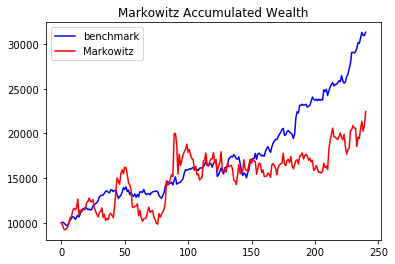

[10000,
 matrix([[ 9745.18413625]]),
 matrix([[ 9317.42266196]]),
 matrix([[ 9213.71015771]]),
 matrix([[ 9354.73768138]]),
 matrix([[ 9527.41967363]]),
 matrix([[ 9995.37262789]]),
 matrix([[ 10597.93084755]]),
 matrix([[ 10689.78838979]]),
 matrix([[ 11357.37860758]]),
 matrix([[ 11624.41469171]]),
 matrix([[ 11469.89808894]]),
 matrix([[ 11689.06733979]]),
 matrix([[ 12661.26843786]]),
 matrix([[ 10857.33018156]]),
 matrix([[ 11409.97754319]]),
 matrix([[ 11252.65121428]]),
 matrix([[ 11498.81315516]]),
 matrix([[ 11468.94545863]]),
 matrix([[ 11527.78255647]]),
 matrix([[ 12283.70220668]]),
 matrix([[ 12384.83173435]]),
 matrix([[ 12778.90885678]]),
 matrix([[ 12384.86892635]]),
 matrix([[ 12370.0217298]]),
 matrix([[ 12602.06733375]]),
 matrix([[ 11684.14227822]]),
 matrix([[ 11304.90947717]]),
 matrix([[ 10954.03795398]]),
 matrix([[ 10678.91053657]]),
 matrix([[ 11154.86970892]]),
 matrix([[ 11266.24839128]]),
 matrix([[ 11679.16511062]]),
 matrix([[ 10610.33338578]]),
 matrix([

In [370]:
runMarkowitz_risky(True)

In [376]:
#######################
######    PGP    ######
#######################

def runPGP(printTrue,Vall,Sall,K1all,K2all,horizon=5,start=10,number_rebalances=240,
           number_of_samples=5,sample_frequency=1,r_w_f_o_y_e=0,
           allowable_risk=allowable_risk,trans_cost=0,initial_wealth=initial_wealth,
           x0=0.,x=(1.0/n)*e):

    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []
    rate_of_decay = 0.

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        mu = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)[0]
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)
        
        R = mu*0.2
        V = np.mat(Vall[id[trade_date]].as_matrix())
        S = np.mat(Sall[id[trade_date]].as_matrix())
        K1 = np.mat(K1all[id[trade_date]].as_matrix())
        K2 = np.mat(K2all[id[trade_date]].as_matrix())
        
        benchmark_risk = sqrt(quad_form(e,V))/n  # there are n financial instruments
        sigma = allowable_risk*benchmark_risk

        xx0 = x0
        xx = x

        x = PGP(R,V,S,K1,K2,xx,trans_cost)
        wealth = wealth*(x0+sum(x))
        x0 = 0.
        
        total = x0+sum(x)
        x0 = x0/total
        x = x/total
        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+np.sum(np.multiply(returns,x))
        wealth = multiplier*wealth

        if(wealth<=0):
            break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = 0.
        x = np.multiply(x,(1.+returns))/multiplier

        #x = np.multiply(x,np.transpose(1.+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs

        benchmark_x0 = 0.
        benchmark_x = (1.+returns)/(n)

        z = rebalance_benchmark_risky(benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n)*z

        portfolio_value.append(wealth)
        benchmark_value.append(benchmark_wealth)
        print trade_date

    PGP_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    PGP_wealth = wealth
    PGP_portfolio_value = portfolio_value
    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "your final wealth:", wealth 
        print "benchmark final wealth:", benchmark_wealth 
        print "your annualized rate of return:", PGP_ret
        print "benchmark annualized rate of return:", benchmark_annual_return
        plt.figure(1)
        plt.title("Markowitz Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
        plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="PGP")
        plt.legend()
        plt.show()
    return PGP_portfolio_value

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
your final wealt

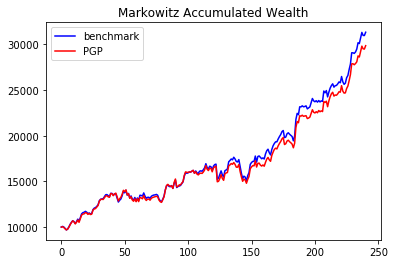

In [377]:
Vall = pm[0]
Sall = pm[1]
K1all = pm[2]
K2all = pm[3]
runPGP(True,Vall,Sall,K1all,K2all)
print ""

In [ ]:
#######################
###### MARKOWITZ ######
#######################
def runMarkowitz(printTrue,horizon=horizon,start=start,number_rebalances=number_rebalances,
                 number_of_samples=number_of_samples,sample_frequency=sample_frequency,r_w_f_o_y_e=r_w_f_o_y_e,
                 allowable_risk=allowable_risk,trans_cost=trans_cost,initial_wealth=initial_wealth,x0=x0,x=x):

    #// rate_of_decay = 0
    rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        # It is more natural to rebalance the benchmark portfolio later #

        mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)

        benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                     # including the bank
        sigma = allowable_risk*benchmark_risk

        xx0 = x0
        xx = x
        #// print "mu", mu.T
        x0,x =  markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost)
        #// print "x0:", x0
        #// print "x:", x.T
        wealth = wealth*(x0+sum(x))
            # This is the same thing as updating your wealth by subtracting
            # all transaction costs from the rebalancing.  Indeed, in rebalancing,
            # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  

        total = x0+sum(x)
        x0 = x0/total
        x = x/total
            # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)

        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+mu0*x0+returns*x
        wealth = multiplier*wealth

        if(wealth<=0):
            break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = (1+mu0)*x0/multiplier
        x = np.multiply(x,np.transpose(1+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs

        benchmark_x0 = (1+mu0)/(n+1)
        benchmark_x = (1+returns)/(n+1)
        # This gives how the equal-weighted portfolio has changed during the time period.
        # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
        # This new level of wealth needs to be distributed equally among the assets and bank.
        # The optimal amount z to put into each one is determined by the following function,
        # which finds the value z so as to minimize transaction costs
        #// print i,"returns:", returns
        #// print "benchmark_x:",benchmark_x

        z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n+1)*z
        #// print "z:",z

        # Until the end of the next time period, 
        # think of the benchmark portfolio as having been rebalanced
        # with wealth divided equally, that is, the portion of wealth invested in
        # each asset and the bank is 1/(n+1).

        portfolio_value.append(wealth)
        benchmark_value.append(benchmark_wealth)

    markowitz_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    Markowitz_wealth = wealth
    markowitz_portfolio_value = portfolio_value
    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "your final wealth:", wealth 
        print "benchmark final wealth:", benchmark_wealth 
        print "your annualized rate of return:", markowitz_ret
        print "benchmark annualized rate of return:", benchmark_annual_return
        plt.figure(1)
        plt.title("Markowitz Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
        plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="Markowitz")
        plt.legend()
        plt.show()
    return markowitz_portfolio_value

In [40]:
#######################
### BLACK LITTERMAN ###
#######################
def runBlackLitterman(TAU,printTrue,num_signal,horizon=horizon,start=start,number_rebalances=number_rebalances,
                     number_of_samples=number_of_samples,sample_frequency=sample_frequency,r_w_f_o_y_e=r_w_f_o_y_e,
                     allowable_risk=allowable_risk,trans_cost=trans_cost,initial_wealth=initial_wealth,x0=x0,x=x,
                      Signal1=Signal1,Signal2=Signal2,Signal3=Signal3,At1=At1,At2=At2,At3=At3,
                      signal_sample_frequency=signal_sample_frequency,
                      number_of_signal_samples=number_of_signal_samples,rate_of_signal_decay=rate_of_signal_decay):
    rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        # Investor view is introduced by calling the investor_view function
        #// A,Omega,b = investor_view(Signal,Returns,trade_date,signal_sample_frequency,
        # number_of_signal_samples,rate_of_signal_decay)   
        #A,Omega,b = hybrid_investor_view(Signal1,Signal2,Signal3,At1,At2,At3,Returns,
        # trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)
        if (num_signal==2):
            A,Omega,b = double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,
                                             signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)
        elif (num_signal==3):
            A,Omega,b = hybrid_investor_view(Signal1,Signal2,Signal3,At1,At2,At3,Returns,
                                             trade_date,signal_sample_frequency,number_of_signal_samples,
                                             rate_of_signal_decay)
        else:
            A,Omega,b = single_investor_view(Signal1,At1,Returns,trade_date,signal_sample_frequency,
                                             number_of_signal_samples,rate_of_signal_decay)

        A.dtype = 'float64'
        mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)

        benchmark_risk = sqrt(quad_form(e,V))/(n+1)
        sigma = allowable_risk*benchmark_risk

        xx0 = x0
        xx = x
        # An optimal weight will be generated using blacklitterman instead of markowitz model 
        x0,x =  blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b,tau=TAU)
        wealth = wealth*(x0+sum(x))

        total = x0+sum(x)
        x0 = x0/total
        x = x/total

        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]

        multiplier = 1+mu0*x0+returns*x
        wealth = multiplier*wealth

        if(wealth<=0):
            break  

        x0 = (1+mu0)*x0/multiplier
        x = np.multiply(x,np.transpose(1+returns))/multiplier

        benchmark_x0 = (1+mu0)/(n+1)
        benchmark_x = (1+returns)/(n+1)

        z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n+1)*z

        portfolio_value.append(wealth)
        benchmark_value.append(benchmark_wealth)
        
    markowitz_portfolio_value=runMarkowitz(False)    
    if (printTrue == True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "your final wealth:", wealth 
        print "benchmark final wealth:", benchmark_wealth 
        BL_Ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
        print "your annualized rate of return:", BL_Ret
        benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
        print "benchmark annualized rate of return:", benchmark_annual_return
        BlackLitterman_wealth = wealth

        plt.figure(2)
        #plt.figure(figsize=(8,6))
        plt.title("Black Litterman Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark",lw = 1)
        plt.plot(range(len(portfolio_value)),portfolio_value,'g',label="BlackLitterman",lw = 3)
        plt.plot(range(len(portfolio_value)),markowitz_portfolio_value,'r',label="Markowitz",lw = 3)
        plt.legend(prop={'size': 8})
        plt.show()

        print "Markowitz_wealth: ", float(Markowitz_wealth),'annualized rate of return:',markowitz_ret
        print "BlackLitterman_wealth: ", float(BlackLitterman_wealth),'annualized rate of return:',BL_Ret
        print "Benchmark: ", benchmark_wealth,'annualized rate of return:',benchmark_annual_return


    RF = np.array([np.array(rf)[i][0] for i in range(len(np.array(rf)))])
    PX_M = np.array(markowitz_portfolio_value)
    PX_B = np.array(portfolio_value)
    BX = np.array(benchmark_value)
    RP_M = np.array([(PX_M[i+1]/PX_M[i]-1.) for i in range(len(PX_M)-1)])
    RP_B = np.array([(PX_B[i+1]/PX_B[i]-1.) for i in range(len(PX_B)-1)])
    RB = np.array([(BX[i+1]/BX[i]-1.) for i in range(len(BX)-1)])
    Sharpe_Ratio_Benchmark = np.mean(RB-RF)/np.std(RB-RF)
    Sharpe_Ratio_Markowitz = np.mean(RP_M-RF)/np.std(RP_M-RF)
    Sharpe_Ratio_BlackLitterman = np.mean(RP_B-RF)/np.std(RP_B-RF)
    if (printTrue==True):
        print "Sharpe Ratio of Benchmark:\t",Sharpe_Ratio_Benchmark
        print "Sharpe Ratio of Markowitz:\t",Sharpe_Ratio_Markowitz
        print "Sharpe Ratio of BlackLitterman:\t",Sharpe_Ratio_BlackLitterman
    return Sharpe_Ratio_BlackLitterman

In [41]:
'''
taulist = np.arange(0.5,5,0.5)
SRlist = []
for TAO in taulist:
    print TAO
    SRlist.append(runBlackLitterman(TAO,False,3))

plt.figure()
plt.plot(taulist,SRlist)
plt.show()
'''

'\ntaulist = np.arange(0.5,5,0.5)\nSRlist = []\nfor TAO in taulist:\n    print TAO\n    SRlist.append(runBlackLitterman(TAO,False,3))\n\nplt.figure()\nplt.plot(taulist,SRlist)\nplt.show()\n'

your final wealth: [[ 18144.27281543]]
benchmark final wealth: 24230.3804969
your annualized rate of return: 0.154101359207
benchmark annualized rate of return: 0.237268677596


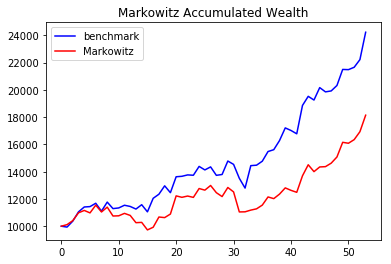

In [46]:
runMarkowitz(True)
print ""

your final wealth: [[ 14267.14160948]]
benchmark final wealth: 24230.3804969
your annualized rate of return: 0.0892516683688
benchmark annualized rate of return: 0.237268677596


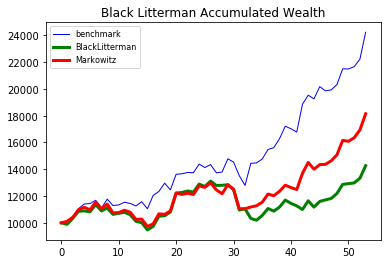

Markowitz_wealth:  18144.2728154 annualized rate of return: 0.154101359207
BlackLitterman_wealth:  14267.1416095 annualized rate of return: 0.0892516683688
Benchmark:  24230.3804969 annualized rate of return: 0.237268677596
Sharpe Ratio of Benchmark:	0.407609770485
Sharpe Ratio of Markowitz:	0.290061461021
Sharpe Ratio of BlackLitterman:	0.181147494659



In [52]:
runBlackLitterman(3,True,2,At1=1,At2=2)
print ""

your final wealth: [[ 14639.7686915]]
benchmark final wealth: 24230.3804969
your annualized rate of return: 0.0960286588662
benchmark annualized rate of return: 0.237268677596


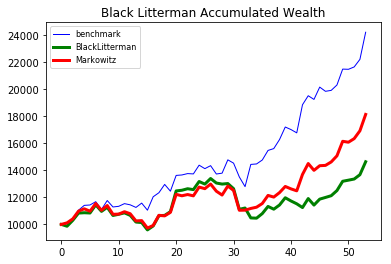

Markowitz_wealth:  18144.2728154 annualized rate of return: 0.154101359207
BlackLitterman_wealth:  14639.7686915 annualized rate of return: 0.0960286588662
Benchmark:  24230.3804969 annualized rate of return: 0.237268677596
Sharpe Ratio of Benchmark:	0.407609770485
Sharpe Ratio of Markowitz:	0.290061461021
Sharpe Ratio of BlackLitterman:	0.190023080108



In [53]:
runBlackLitterman(3,True,1,At1=1)
print ""